# Wordle

### Abstract

Wordle is an imperfect information codeword completion game which is closely related to mastermind. This notebook is created to explore the implementation of an automated solver for wordle. I will assume familiarity with both games, and this notebook will refer to results and explanations in the mastermind notebook.

The main differences between Wordle and mastermind are:

1. The response message. In mastermind, the response message is a 2-tuple (n_exact_matches, n_color_matches) encoding how many, but not which, symbols are correct. In Wordle, the response does tell the codebreaker which of the symbols are correct, hence the response message in a wordle could be represented as a vector.
1. The initial codeword pool. In mastermind, the codeword pool is the space of all possible codewords. Where the number of symbols is $S$, and the codeword length is $L$, the initial pool size is $S^L$. For classic mastermind, also called MM(4,6) in the literature, $S=6$, $L=4$, and $S^L=1296$. In Wordle, although $S=26$ and $L=5$, the size of the initial pool is much smaller than $26^5\approx 1.188\times 10^7$ because we're limited to a small subset of valid words in English.

Unlike the mastermind jupyter notebook, I'll be writing most of the source code for the Wordle solver in python files as opposed to being within this notebook, so the code is better structured.

### The wordlist

Wordle's original wordlist is easily extracted from the minified javascript source, which is available via the Internet Archive.

From the [archived source](https://web.archive.org/web/20220210031511id_/https://www.powerlanguage.co.uk/wordle/), locate `main.e65ce0a5.js`. Locate the two minified variables called `La` and `Ta`. It's easier if we unminify the source first but these variables are obvious because they're just long lists of strings. `La` contains a list of more common words, which I believe consist of words which could be solutions. `Ta` contains a list of less common words which are nontheless accepted as valid attempts, but would never be the solution to a puzzle. Any other codeword, when entered, would prompt an invalid codeword message, but would not consume a try nor elicit any kind of response. The goal is to guess correctly within 5 tries.

In this notebook, I'll call codewords which are potential solutions "candidates". The union of all codewords under both `La` and `Ta` variables is simply called the "pool" of codewords. I've extracted the codewords under `La` and `Ta` to `data/original_candidates.txt` and `data/original_valid.txt` respectively.

For the solver to operate efficiently, we enumerate the entire symbol list as well as the response vector with integers.

In [1]:
# NOTEBOOK DIRECTIVES
# Setup autoreload
%load_ext autoreload
%autoreload 2

# Setup matplotlib
%matplotlib inline

In [25]:
# IMPORTS
import cupy as cp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess

from wordlist import ( WordleWordlistOriginal )
from solver import ( WordleSolver, WordleMinimaxSolver )

In [27]:
# Load wordlist
wordlist = WordleWordlistOriginal()
print(wordlist)

WordleWordlistOriginal(n_syms=26, length=5, n_candidates=2315, n_valid=10657)


## Data exploration

### Distribution of symbols in solution codewords

Okay, let's start by exploring the data. To begin with, what is the global distribution of letters in the words which are potentially solutions?

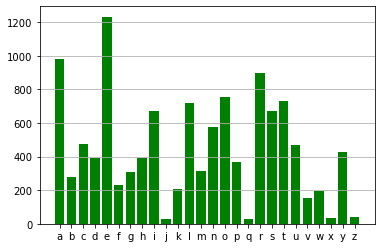

In [28]:
dist_sol_global = wordlist.get_symbol_counts_global(wordlist.candidates)
bar = plt.bar(np.arange(len(wordlist.symbols)), dist_sol_global, facecolor='g', tick_label=wordlist.symbols)
plt.grid(which='major', axis='y')
plt.show()

And what about the symbol distribution at each position of the codeword? This will be the key to finding an efficient partitioning of the solution space.

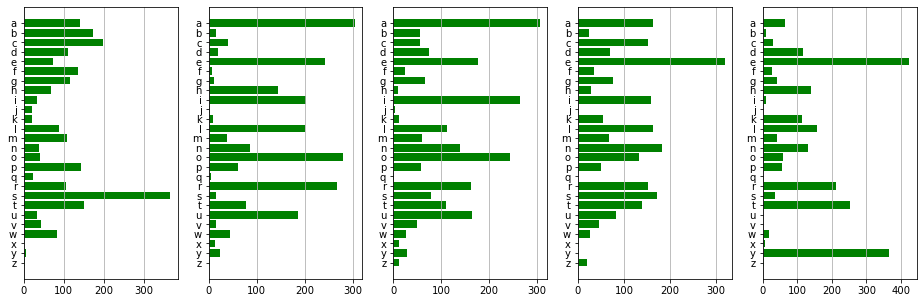

In [29]:
dist_sol_pos = wordlist.get_symbol_counts_by_position(wordlist.candidates)
fig, axs = plt.subplots(1,5, figsize=(16,5))
for i in range(5):
    axs[i].barh(np.arange(len(wordlist.symbols)), dist_sol_pos[i], facecolor='g', tick_label=wordlist.symbols)
    axs[i].grid(which='major', axis='x')
    axs[i].invert_yaxis()
plt.show()

### CUDA

Brute-forcing Wordle using Minimax requires big matrix operations e.g. tensors of shape (10k, 2k, 5). Although I've written the code to be CPU/GPU-agnostic, for performance reasons (about 2 orders of magnitude faster) we'll want to be using a CUDA-compatible GPU when running this notebook. Our main concern when working with giant matrices is available GPU memory. If we hit this limit, we'll have to batch the data and reassemble the matrices, which adds to complexity and detracts from the purpose of this notebook.

This notebook is written to run on a single GeForce GTX1080 GPU. If for any reason a cell terminates prematurely, e.g. out of memory to allocate, some or all of the allocated GPU memory may not be freed. This is expected behavior as CuPy caches the memory (see [here](https://docs.cupy.dev/en/latest/user_guide/memory.html)). Calling `cupy.get_default_memory_pool().free_all_blocks()` would free all such memory. The alternative would be to shut down the kernel of this notebook. If you're new to Jupyter, you can do this from the bar at the top: Kernel --> Shutdown. With CUDA properly installed, we can check used / available GPU memory by running `nvidia-smi` from the terminal. If some subsequent cell (or some other process) is having trouble allocating device memory or is running slower than expected, it may be a good idea to check.

In [45]:
# Run to free all cached GPU memory
cp.get_default_memory_pool().free_all_blocks()

In [46]:
# Check that CUDA is properly set up and that the GPU is accessible.
print(cp.cuda.runtime.getDeviceCount())
cp.cuda.runtime.getDeviceProperties(0)

1


{'name': b'NVIDIA GeForce GTX 1080',
 'totalGlobalMem': 8589737984,
 'sharedMemPerBlock': 49152,
 'regsPerBlock': 65536,
 'warpSize': 32,
 'maxThreadsPerBlock': 1024,
 'maxThreadsDim': (1024, 1024, 64),
 'maxGridSize': (2147483647, 65535, 65535),
 'clockRate': 1847000,
 'totalConstMem': 65536,
 'major': 6,
 'minor': 1,
 'textureAlignment': 512,
 'texturePitchAlignment': 32,
 'multiProcessorCount': 20,
 'kernelExecTimeoutEnabled': 1,
 'integrated': 0,
 'canMapHostMemory': 1,
 'computeMode': 0,
 'maxTexture1D': 131072,
 'maxTexture2D': (131072, 65536),
 'maxTexture3D': (16384, 16384, 16384),
 'concurrentKernels': 1,
 'ECCEnabled': 0,
 'pciBusID': 1,
 'pciDeviceID': 0,
 'pciDomainID': 0,
 'tccDriver': 0,
 'memoryClockRate': 5005000,
 'memoryBusWidth': 256,
 'l2CacheSize': 2097152,
 'maxThreadsPerMultiProcessor': 2048,
 'isMultiGpuBoard': 0,
 'cooperativeLaunch': 1,
 'cooperativeMultiDeviceLaunch': 0,
 'deviceOverlap': 1,
 'maxTexture1DMipmap': 16384,
 'maxTexture1DLinear': 268435456,
 'ma

### Minimax algorithm. Single-step lookahead (greedy)

So, let's apply the minimax algorithm which Knuth demonstrated as a solution for MM(4,6) mastermind, to solve Wordle. Recall that in Minimax, we take the guess whose largest set partition is smallest (among all the guesses).

We do need to modify our mastermind implementation, because in Wordle, the set of codewords which are candidate solutions, is distinct from the set of all other valid words. Observe that this could be simply viewed as an artificial partitioning of the initial pool into a smaller set of candidate codewords.

We will also make one more modification. Recall that at the end of the mastermind notebook, we noted the known result, that guessing only within the set of candidate codewords is suboptimal. Since we have to maintain two sets of codewords in Wordle anyway (one to guess with, one to partition down to the solution), our Wordle minimax algorithm will be free to choose any word in the pool i.e. candidates $\cup$ valid at any time step.

In [32]:
solver = WordleMinimaxSolver(wordlist)
print(solver)

WordleMinimaxSolver(n_candidates=2315, n_valid=10657)


In [41]:
answer, nsteps, guesses, messages = solver.solve("haute", max_iters=10)
print(f"SOLVED after: {nsteps} steps")

Guess: 'arise', response: [1 0 0 0 2]
Partition: ['badge', 'bathe', 'blade', 'blame', 'blaze', 'cable', 'cache', 'canoe', 'chafe', 'dance', 'eagle', 'elate', 'evade', 'fable', 'flake', 'flame', 'gaffe', 'gauge', 'gauze', 'glade', 'glaze', 'halve', 'haute', 'heave', 'knave', 'ladle', 'lance', 'lathe', 'latte', 'leave', 'mange', 'maple', 'mauve', 'maybe', 'ovate', 'payee', 'peace', 'place', 'plane', 'plate', 'quake', 'table', 'vague', 'value', 'valve', 'weave', 'whale']
Guess: 'blaud', response: [0 0 1 1 0]
Partition: ['gauge', 'gauze', 'haute', 'mauve']
Guess: 'aargh', response: [1 2 0 0 1]
Partition: ['haute']
Guess: 'haute', response: [2 2 2 2 2]
SOLVED after: 4 steps


How about a truth value where the word 'arise' matches nothing initially?

In [42]:
answer, nsteps, guesses, messages = solver.solve("colon", max_iters=10)
print(f"SOLVED after: {nsteps} steps")

Guess: 'arise', response: [0 0 0 0 0]
Partition: ['block', 'blond', 'blood', 'bloom', 'blown', 'bluff', 'blunt', 'bobby', 'bongo', 'booby', 'booth', 'booty', 'boozy', 'botch', 'bough', 'bound', 'buddy', 'buggy', 'bulky', 'bully', 'bunch', 'bunny', 'butch', 'buxom', 'chock', 'chuck', 'chump', 'chunk', 'clock', 'cloth', 'cloud', 'clout', 'clown', 'cluck', 'clump', 'clung', 'colon', 'comfy', 'conch', 'condo', 'couch', 'cough', 'could', 'count', 'coyly', 'dodgy', 'dolly', 'donut', 'doubt', 'dough', 'dowdy', 'downy', 'duchy', 'dully', 'dummy', 'dumpy', 'dutch', 'flock', 'flood', 'flout', 'flown', 'fluff', 'flung', 'flunk', 'foggy', 'folly', 'found', 'fully', 'funky', 'funny', 'fuzzy', 'ghoul', 'gloom', 'glyph', 'godly', 'golly', 'goody', 'goofy', 'gulch', 'gully', 'gumbo', 'gummy', 'guppy', 'hobby', 'holly', 'hotly', 'hound', 'howdy', 'humph', 'hunch', 'hunky', 'hutch', 'jolly', 'jumbo', 'jumpy', 'junto', 'knock', 'knoll', 'known', 'lobby', 'lofty', 'loopy', 'lowly', 'lucky', 'lumpy', 'lunc

Did you notice anything unusual with the solution path above? The same thing happened in the cell below, too. This is mostly to illustrate an edge case when generating the lookup tree (see below). If the algorithm picks a word that's in the solution to partition the solution pool, that pick may actually be the solution itself. In that case, we don't actually need to travel further down the tree to find the solution.

In [43]:
answer, nsteps, guesses, messages = solver.solve("gypsy", max_iters=10)
print(f"SOLVED after: {nsteps} steps")

Guess: 'arise', response: [0 0 0 2 0]
Partition: ['blush', 'boost', 'bossy', 'floss', 'flush', 'fussy', 'ghost', 'gloss', 'gypsy', 'hussy', 'joust', 'lousy', 'mossy', 'plush', 'shush', 'slosh', 'slush']
Guess: 'shlub', response: [1 0 0 0 0]
Partition: ['gypsy', 'mossy']
Guess: 'gypsy', response: [2 2 2 2 2]
Partition: ['gypsy']
Guess: 'gypsy', response: [2 2 2 2 2]
SOLVED after: 4 steps


### Generating the lookup tree

Okay! With that in mind, let's generate a lookup tree. Running minimax every time is very wasteful because we're recomputing the partitioning every single time. A better tradeoff would be to generate and then store the full tree that partitions the solution space, and then simply do a lookup without having to do giant matrix operations.

What would this tree look like?

1. Each node of the tree would have a 2-tuple `(candidates, guess)`. The guess is necessary because of the edge case that we've shown earlier.
1. Every node would have a maximum branching factor which equals `n_keys`.

We could generate the tree using greedy minimax as it is, for vanilla Wordle. For larger problems e.g. if allow all valid words as candidates, we quickly start running into memory constraints computing minimax, so we need to start looking at graph algorithms. Branch and bound seems like a good option. Branch and bound isn't good for when we have combinatorial explosions (e.g. cutting stock, knapsack) but should work just fine for Wordle.

In [44]:
cp.get_default_memory_pool().free_all_blocks()